# Proyecto de Máquinas de Aprendizaje - ILI393
## _Identificación facial cuando existen pocos ejemplos por clase_

## El Problema

blabla

## Enfoque 1: Linear Discriminant Analysis

#####################################################################################
Dataset faces94: 2 samples per class
Error rate: 0.980132450331


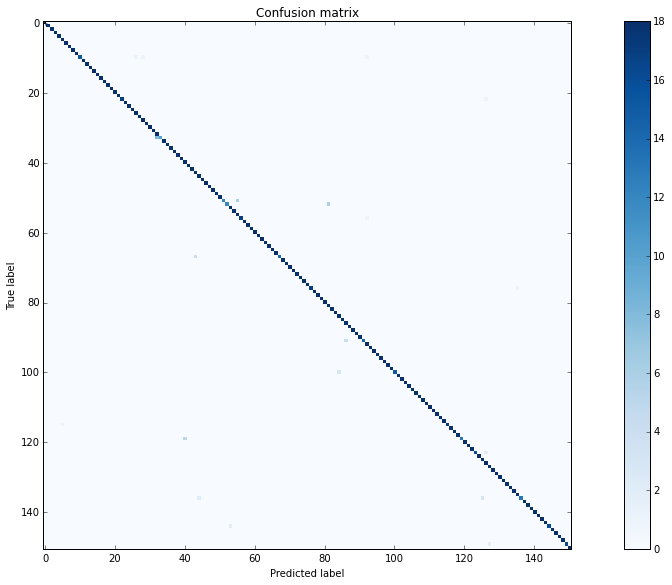

#####################################################################################
#####################################################################################
Dataset faces94: 3 samples per class
Error rate: 0.997273081418


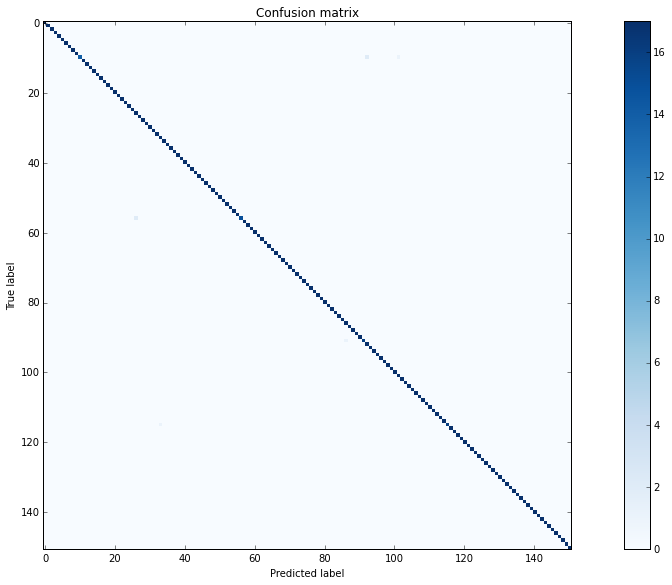

#####################################################################################
#####################################################################################
Dataset faces94: 4 samples per class
Error rate: 0.992963576159


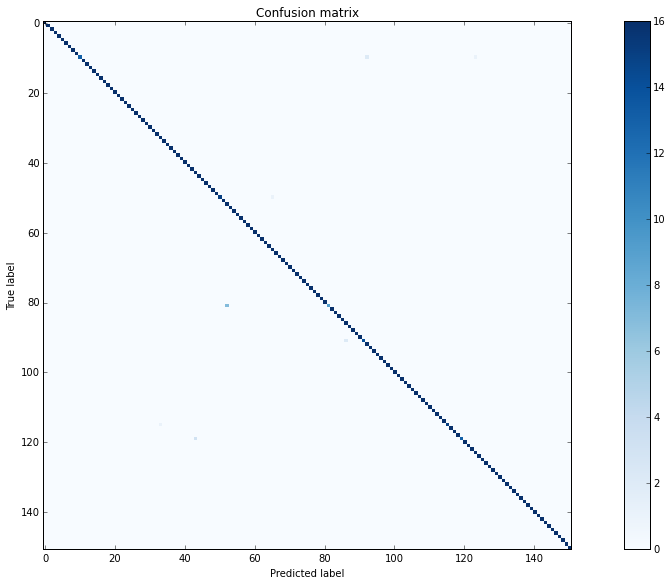

#####################################################################################
#####################################################################################
Dataset faces94: 5 samples per class
Error rate: 0.99646799117


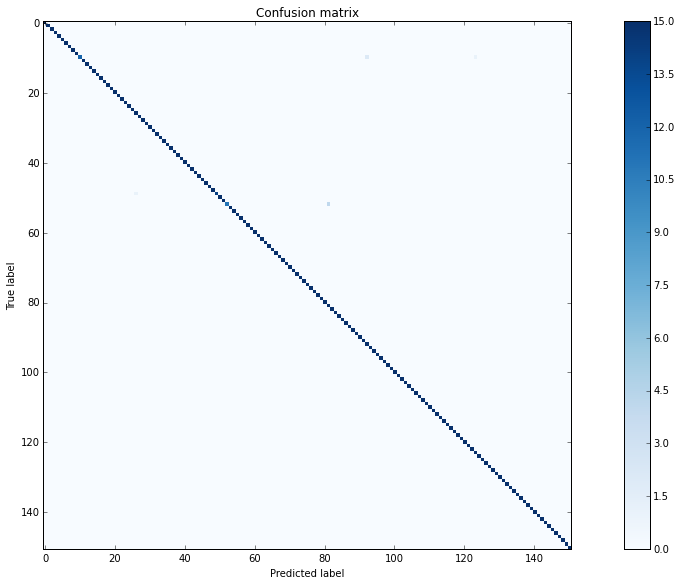

#####################################################################################


In [95]:
for i in range(2,6):
    solve_lda('faces94',i)

#####################################################################################
Dataset faces95: 2 samples per class
Error rate: 0.639280125196


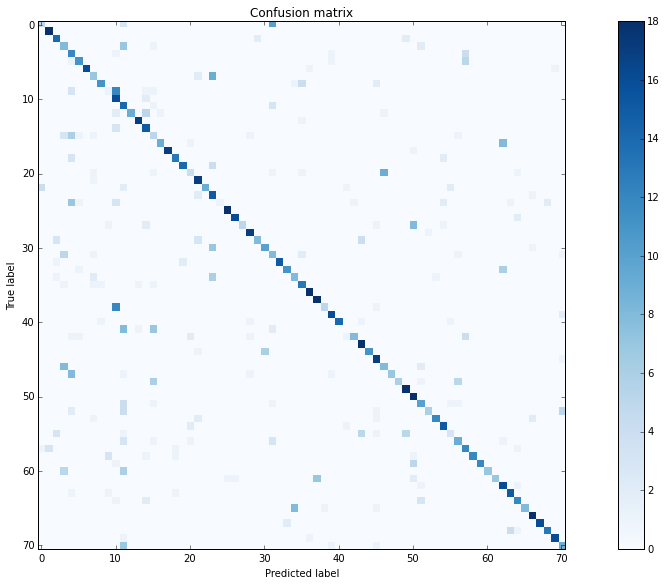

#####################################################################################
#####################################################################################
Dataset faces95: 3 samples per class
Error rate: 0.737365368683


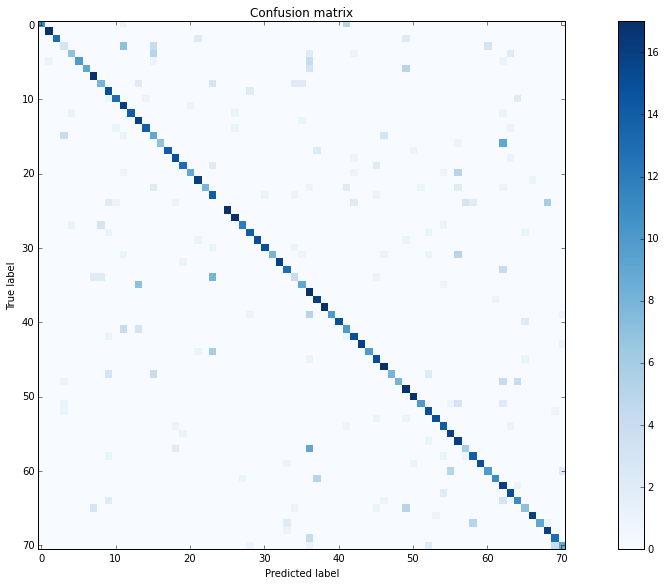

#####################################################################################
#####################################################################################
Dataset faces95: 4 samples per class
Error rate: 0.802816901408


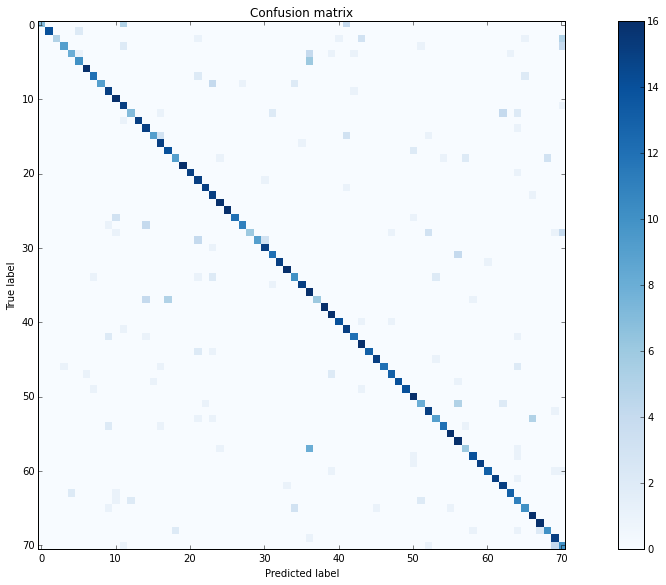

#####################################################################################
#####################################################################################
Dataset faces95: 5 samples per class
Error rate: 0.851643192488


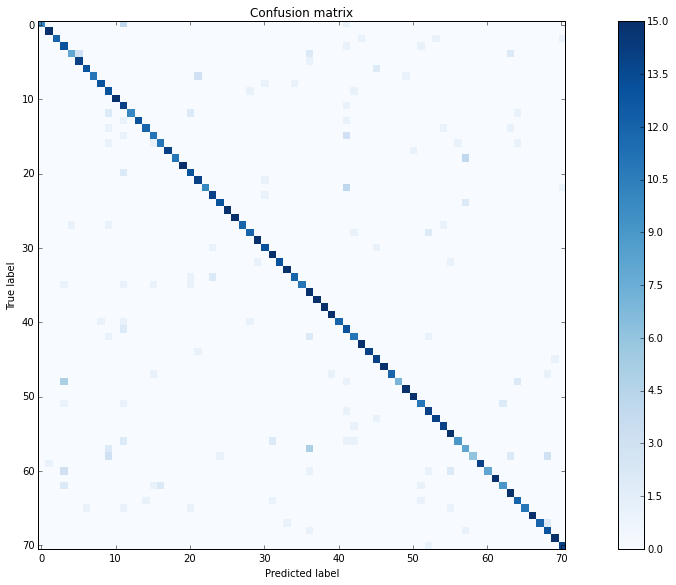

#####################################################################################


In [97]:
for i in range(2,6):
    solve_lda('faces95',i)

## Enfoque 2: Support Vector Machines

### 1) Linear-SVM

### 2) Kernel-SVM

## Enfoque 3: Convolutional Neural Network

## Anexo de Código

### Configuración del notebook

In [105]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### Helper functions

In [90]:
"""
> function to load data from path directory to a matrix.
> each row of the resulting matrix, corresponds to a flattened image
  in grayscale format
"""
def load_data(path, spc):
    path = path+str(spc)+'pc/'
    #total number of classes
    M = len(os.listdir(path))
    #dimensions of each image
    N = 200*180
    #matrix with features and labels
    data = np.empty((M*spc,N+1))
    #index of data matrix
    m = 0
    for i in range(1,M+1):
        tgt = path+str(i)+'/'
        pics = os.listdir(tgt)
        for pic in pics:
            #store each flattened image, as a row in data matrix
            data[m,0:-1] = cv.imread(tgt+pic, cv.IMREAD_GRAYSCALE).ravel()
            data[m,-1] = i
            m +=1
    #just to verify that orden doesn't affect results
    np.random.shuffle(data)
    return (data[:,0:-1], data[:,-1])

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Funciones de error

In [87]:
def error_rate(y_ts, y_pd):
    #true positives
    tp = (y_ts==y_pd).sum()
    #total of predictions
    n = y_ts.shape[0]
    return tp/np.float(n)

### Funciones para LDA

In [94]:
def solve_lda(dataset, spc):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #loading training and testing set
    X_tr,y_tr = load_data('./db/train'+dataset[-2:]+'/', spc_tr)
    X_ts,y_ts = load_data('./db/test'+dataset[-2:]+'/', spc_ts)
    #creating LDA object and fitting the testing data
    clf = LDA()
    clf.fit(X_tr, y_tr)
    #making predictions
    y_pd = clf.predict(X_ts)
    
    print "#####################################################################################"
    print "Dataset {0}: {1} samples per class".format(dataset,spc)
    #computing the confussion matrix and plotting results
    print "Error rate: {0}".format(error_rate(y_ts,y_pd))
    cm = confusion_matrix(y_ts, y_pd)
    plot_confusion_matrix(cm)
    print "#####################################################################################"
    #releasing memory of big objects
    del X_tr, X_ts, clf, cm

### Funciones para SVM

In [109]:
"""
Supervised dimensionality reduction through LDA
"""
def fisher_faces(X, y):
    #supervised learning through LDA
    #finding the discriminant functions
    clf = LDA()
    clf.fit(X,y)
    #proyect the data into linear discriminant hyperplanes
    X_red = clf.transform(X)
    del clf
    return X_red

def cross_c(X, y, C):
    M,N = X.shape
    #generating 5-folds
    kf = KFold(M, n_folds=5)
    #array with CV-errors
    cv_err = np.empty((5,5))
    #index of parameter
    j = 0 
    for c in C:
        clf = SVC(c)
        #index of fold
        i=0
        for tr_index,ts_index in kf:
            X_tr,y_tr = X[tr_index], y[tr_index]
            X_ts,y_ts = X[ts_index], y[ts_index]
            #fitting the model
            clf.fit(X_tr,y_tr)
            #making predictions
            y_pd = clf.predict(X_ts)
            #computing error rate
            cv_err[i,j] = error_rate(y_ts, y_pd)
            i +=1
        j += 1
    #mean cv-error
    cv_mean = np.mean(cv_err, axis=0)
    return C[np.argmin(cv_mean)], cv_err

def solve_svm(dataset, spc, C):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #loading training and testing set
    X_tr,y_tr = load_data('./db/train'+dataset[-2:]+'/', spc_tr)
    X_ts,y_ts = load_data('./db/test'+dataset[-2:]+'/', spc_ts)
    #projecting into discriminant space
    X_tr = fisher_faces(X_tr, y_tr)
    X_ts = fisher_faces(X_ts, y_ts)
    #chossing best C
    c,cv_err = cross_c(X_tr, y_tr, C)
    #fitting the model
    clf = SVC(c)
    clf.fit(X_tr,y_tr)
    #making predictions
    y_pd = clf.predict(X_ts)
    
    print "#####################################################################################"
    print "Dataset {0}: {1} samples per class".format(dataset,spc)
    print "Error rate: {0}".format(error_rate(y_ts,y_pd))
    #computing the confussion matrix and plotting results
    cm = confusion_matrix(y_ts, y_pd)
    plot_confusion_matrix(cm)
    print "#####################################################################################"

In [110]:
C = np.linspace(1.,5.,5)

In [ ]:
solve_svm('faces94',5,C)